# 0. Librerias necesarias

In [2]:
import warnings 
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import os
from glob import glob
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from scipy import ndimage
import cv2

# 1. Análisis Exploratrorio

Descripcion de la base:


ORIGA(-light) contiene 650 imágenes retinianas anotadas por profesionales formados del Instituto de Investigación Ocular de Singapur.

La base de datos está compuesta por un conjunto de imágenes y un archivo en formato CSV que contiene las columnas que se aprecian a continuación:

Las  columnas (Image, CDR, Ecc-Cup, Ecc-Disc)  corresponden a variables explicativas y la última (Glaucoma) corresponde a nuestra variable clasificatoria.

 Cada una de estas columnas se explica de la siguiente manera:


- Image: Nombre de archivo de imagen.
- Source: Fuente del dato
- CDR: Cup-to-Disc Ratio. Proporción entre el diámetro del "cup" (excavación central) y el disco óptico. Valor clave en la detección de glaucoma..
- Ecc-Cup: Excentricidad de la región de excavación del nervio óptico (cup). Una medida morfológica.
- Ecc-Disc: Excentricidad del disco óptico completo. Ayuda a describir la forma del disco.
- Glaucoma: Variable clasificatoria que identifica el diagnóstico negativo (0) o positivo (1) del glaucoma

In [3]:
df_origa = pd.read_csv('ORIGA/origa_info.csv')
df_origa

,Image,Source,CDR,Ecc-Cup,Ecc-Disc,Glaucoma
0,001.jpg,Origa,0.7097,0.636027,0.580909,0
1,002.jpg,Origa,0.6953,0.575024,0.608413,0
2,003.jpg,Origa,0.9629,0.299303,0.262828,0
3,004.jpg,Origa,0.7246,0.503186,0.483273,0
4,005.jpg,Origa,0.6138,0.500141,0.283467,0
...,...,...,...,...,...,...
645,646.jpg,Origa,0.6560,0.123190,0.264288,1
646,647.jpg,Origa,0.7365,0.602515,0.528356,1
647,648.jpg,Origa,0.5101,0.295414,0.549101,1
648,649.jpg,Origa,0.5227,0.624191,0.383839,0


Revisamos la proporción de la variable objetivo:

In [4]:
labels_counts = df_origa["Glaucoma"].value_counts()
labels_counts

Glaucoma
0    482
1    168
Name: count, dtype: int64

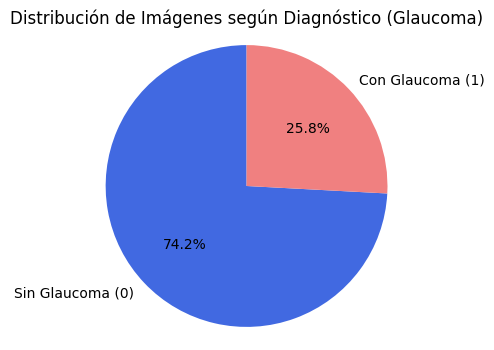

In [5]:
plt.figure(figsize=(4, 4))
plt.pie(labels_counts, 
        labels=['Sin Glaucoma (0)', 'Con Glaucoma (1)'],
        autopct='%1.1f%%',
        colors=['royalblue', 'lightcoral'],
        startangle=90)
plt.title('Distribución de Imágenes según Diagnóstico (Glaucoma)')
plt.axis('equal')  # Para que sea un círculo perfecto
plt.show()



Revisamos la distribución de CDR por la clasificación de Glaucoma'

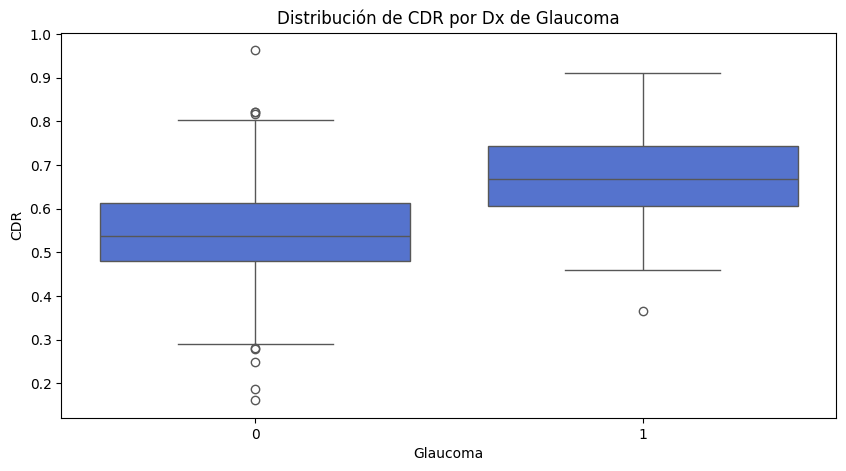

In [6]:
plt.figure(figsize=(10,5))

sns.boxplot(x='Glaucoma', y='CDR', data=df_origa, color="royalblue")
plt.title('Distribución de CDR por Dx de Glaucoma')
plt.show()


Agregamos la ruta completa de la imagen al dataset

In [7]:
all_images = glob("ORIGA\Images\*.jpg")
root = "ORIGA\Images"
df_origa["Path"] = df_origa["Image"].apply(lambda fn: os.path.join(root, fn))
df_origa.head()

,Image,Source,CDR,Ecc-Cup,Ecc-Disc,Glaucoma,Path
0,001.jpg,Origa,0.7097,0.636027,0.580909,0,ORIGA\Images\001.jpg
1,002.jpg,Origa,0.6953,0.575024,0.608413,0,ORIGA\Images\002.jpg
2,003.jpg,Origa,0.9629,0.299303,0.262828,0,ORIGA\Images\003.jpg
3,004.jpg,Origa,0.7246,0.503186,0.483273,0,ORIGA\Images\004.jpg
4,005.jpg,Origa,0.6138,0.500141,0.283467,0,ORIGA\Images\005.jpg


Las imágenes que provee el dataset corresponden a fondos oculares como el siguiente

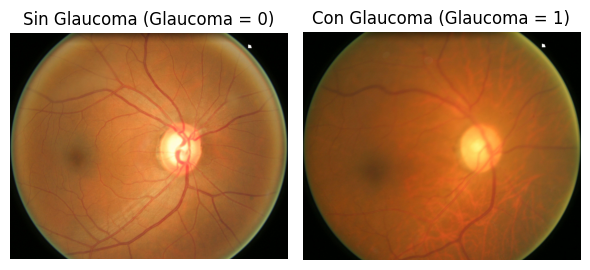

In [8]:
# Obtener ruta de una imagen con Glaucoma = 0 (sin glaucoma)
img_path_0 = df_origa[df_origa["Glaucoma"] == 0]["Path"].iloc[0]
img_0 = Image.open(img_path_0)

# Obtener ruta de una imagen con Glaucoma = 1 (con glaucoma)
img_path_1 = df_origa[df_origa["Glaucoma"] == 1]["Path"].iloc[0]
img_1 = Image.open(img_path_1)


fig, axes = plt.subplots(1, 2, figsize=(6,5))

axes[0].imshow(img_0)
axes[0].set_title("Sin Glaucoma (Glaucoma = 0)")
axes[0].axis("off")

axes[1].imshow(img_1)
axes[1].set_title("Con Glaucoma (Glaucoma = 1)")
axes[1].axis("off")

plt.tight_layout()
plt.show()


Las imágenes anteriores muestran fondos oculares diagnosticados de glaucoma de forma negativa (imagen de la izquiera) y positiva (imagen de la derecha).

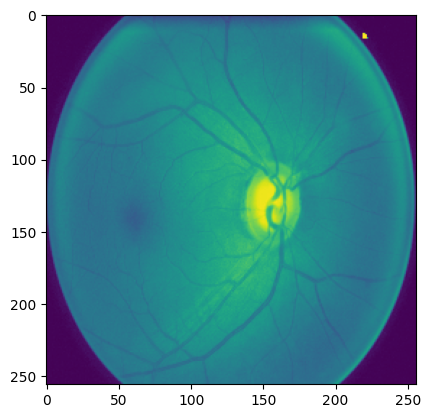

In [11]:
img_path_0 = df_origa[df_origa["Glaucoma"] == 0]["Path"].iloc[0]
image_0 = cv2.imread(img_path_0, cv2.IMREAD_GRAYSCALE)
image_0 = cv2.resize(image_0, (256, 256))

plt.imshow(image_0)


# 3. Feature Enginier

CLAHE es una técnica que mejora el contraste localmente, haciendo visibles detalles importantes, especialmente en imágenes médicas. Es útil en imágenes de retina para resaltar estructuras como el disco óptico y los vasos sanguíneos.

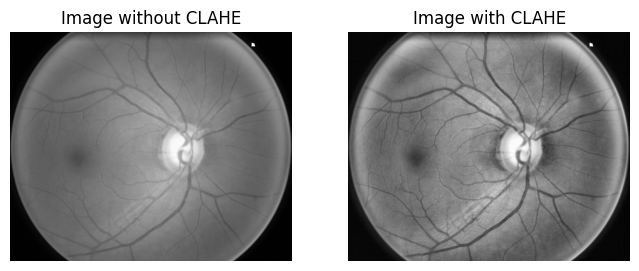

In [20]:
# displaying image normally and after applying CLAHE enhancement
sample_image_path= df_origa.loc[0,'Path'] #Secting a sample image from the dataset
sample_image=cv2.imread(sample_image_path,cv2.IMREAD_GRAYSCALE)

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
image_clahe = clahe.apply(sample_image) 

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.imshow(sample_image,cmap = 'gray')
plt.title("Image without CLAHE")
plt.axis(False)

plt.subplot(1,2,2)
plt.imshow(image_clahe,cmap='gray')
plt.title("Image with CLAHE")
plt.axis(False)

plt.show()